In [115]:
!pip install flax

from tqdm.auto import tqdm

import h5py
import numpy as np

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt


# Make sure tf does not allocate gpu memory.
tf.config.experimental.set_visible_devices([], "GPU")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2022-11-14 12:26:51--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  30.1MB/s    in 7.9s    

2022-11-14 12:26:59 (25.5 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



In [16]:
# Get milky way similar galaxies, ref.: https://astronn.readthedocs.io/en/latest/galaxy10sdss.html
with h5py.File('Galaxy10.h5', 'r') as F:
  labels = np.array(F['ans'])
  # Milky way similar galaxies are class '7'
  (milkywaylikes_idx,) = np.where(labels == 7)
  images = np.array(F['images'][milkywaylikes_idx])

images = images.astype(np.float32) / 255.

print(images.shape)

(1121, 69, 69, 3)


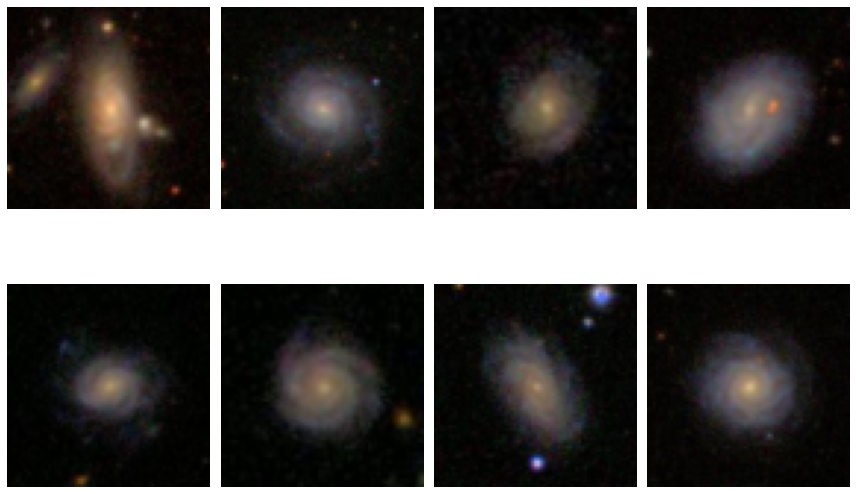

In [17]:
%matplotlib inline

def show_galaxies(images: np.ndarray) -> None:
  n = len(images)
  # always 4 in a column
  ncols = 4
  nrows = -(-n // ncols)
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img)
    ax.axis('off')
    fig.tight_layout()

# plot first 8 images
show_galaxies(images[:8])

In [141]:
# VAE model
def reparameterize(rng, mean, logvar):
  std = jnp.exp(0.5 * logvar)
  eps = jax.random.normal(rng, logvar.shape)
  return mean + eps * std


class Encoder(nn.Module):
  latents: int

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(500, name='fc1')(x)
    x = nn.relu(x)
    x = nn.Dense(250, name='fc2')(x)
    x = nn.relu(x)
    x = nn.Dense(100, name='fc3')(x)
    x = nn.relu(x)
    mean_x = nn.Dense(self.latents, name='fc4_mean')(x)
    logvar_x = nn.Dense(self.latents, name='fc4_logvar')(x)
    return mean_x, logvar_x


class Decoder(nn.Module):

  @nn.compact
  def __call__(self, z):
    z = nn.Dense(100, name='fc1')(z)
    z = nn.relu(z)
    z = nn.Dense(250, name='fc2')(z)
    z = nn.relu(z)
    z = nn.Dense(500, name='fc3')(z)
    z = nn.relu(z)
    # output size must have dimension of original image
    z = nn.Dense(69*69*3, name='fc4')(z)
    return z


class VAE(nn.Module):
  latents: int = 20

  def setup(self):
    self.encoder = Encoder(self.latents)
    self.decoder = Decoder()

  def __call__(self, x, z_rng):
    mean, logvar = self.encoder(x)
    z = reparameterize(z_rng, mean, logvar)
    recon_x = self.decoder(z)
    return recon_x, mean, logvar

  def generate(self, z):
    return nn.sigmoid(self.decoder(z))


In [142]:
# Losses
@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))


@jax.vmap
def binary_cross_entropy_with_logits(logits, labels, weight = 5000.):
  logits = nn.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits))) / weight
  

def compute_metrics(recon_x, x, mean, logvar):
  bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
  kld_loss = kl_divergence(mean, logvar).mean()
  return {
      "bce": bce_loss,
      "kld": kld_loss,
      "loss": bce_loss + kld_loss
  }

In [147]:
learning_rate = 1e-4
epochs = 30
latents = 32
batch_size = 64

# init model
model = VAE(latents)


# prepare images
# flatten & unflatten images
def flatten(images):
  return jnp.reshape(images, (-1, 69*69*3))

def unflatten(images):
  return jnp.reshape(images, (-1, 69, 69, 3))


# use 1000 for training, rest for testing
split = 1000
train_idx, test_idx = slice(0, split), slice(split, -1)

# train
train_images = flatten(jnp.asarray(images[train_idx]))

n_train_images = len(train_images)

# test
test_images = flatten(jnp.asarray(images[test_idx]))

In [149]:
%matplotlib inline

# define train state
rng = jax.random.PRNGKey(0)
rng, key = jax.random.split(rng)
init_data = jnp.ones((batch_size, *train_images.shape[1:]), jnp.float32)

state = train_state.TrainState.create(
  apply_fn=model.apply,
  params=model.init(key, init_data, rng)['params'],
  tx=optax.adam(learning_rate),
)


# extract metrics
@jax.jit
def evaluate(params, images, z_rng):
  def evaluate_fn(model):
    recon_images, mean, logvar = model(images, z_rng)
    metrics = compute_metrics(recon_images, images, mean, logvar)
    return metrics
  return nn.apply(evaluate_fn, model)({'params': params})


# one train step
@jax.jit
def train_step(state, batch, z_rng):
  def loss_fn(params):
    recon_x, mean, logvar = model.apply({'params': params}, batch, z_rng)
    bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    loss = bce_loss + kld_loss
    return loss

  # calculate gradient & apply
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)


# training loop
steps_per_epoch = n_train_images // batch_size
for epoch in tqdm(range(epochs), unit="epoch"):
  perms = jax.random.permutation(rng, n_train_images)
  # skip incomplete batch
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))

  for perm in perms:
    batch = train_images[perm, ...]
    state = train_step(state, batch, key)
    rng, key = jax.random.split(rng)

  metrics = evaluate(state.params, test_images, rng)

  tqdm.write("epoch: {} - loss: {:.4f} - BCE: {:.4f} - KLD: {:.4f}".format(
      epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
  ))

  0%|          | 0/30 [00:00<?, ?epoch/s]

epoch: 1 - loss: 1.8516 - BCE: 1.8513 - KLD: 0.0003
epoch: 2 - loss: 1.6220 - BCE: 1.6219 - KLD: 0.0001
epoch: 3 - loss: 1.2728 - BCE: 1.2727 - KLD: 0.0001
epoch: 4 - loss: 0.9428 - BCE: 0.9425 - KLD: 0.0003
epoch: 5 - loss: 0.8098 - BCE: 0.8096 - KLD: 0.0002
epoch: 6 - loss: 0.7726 - BCE: 0.7722 - KLD: 0.0003
epoch: 7 - loss: 0.7683 - BCE: 0.7682 - KLD: 0.0001
epoch: 8 - loss: 0.7465 - BCE: 0.7463 - KLD: 0.0002
epoch: 9 - loss: 0.7506 - BCE: 0.7503 - KLD: 0.0003
epoch: 10 - loss: 0.7468 - BCE: 0.7467 - KLD: 0.0000
epoch: 11 - loss: 0.7502 - BCE: 0.7502 - KLD: 0.0000
epoch: 12 - loss: 0.7514 - BCE: 0.7514 - KLD: 0.0000
epoch: 13 - loss: 0.7485 - BCE: 0.7485 - KLD: 0.0000
epoch: 14 - loss: 0.7468 - BCE: 0.7468 - KLD: 0.0000
epoch: 15 - loss: 0.7458 - BCE: 0.7458 - KLD: 0.0000
epoch: 16 - loss: 0.7448 - BCE: 0.7448 - KLD: 0.0000
epoch: 17 - loss: 0.7461 - BCE: 0.7461 - KLD: 0.0000
epoch: 18 - loss: 0.7450 - BCE: 0.7450 - KLD: 0.0000
epoch: 19 - loss: 0.7426 - BCE: 0.7426 - KLD: 0.0000
ep

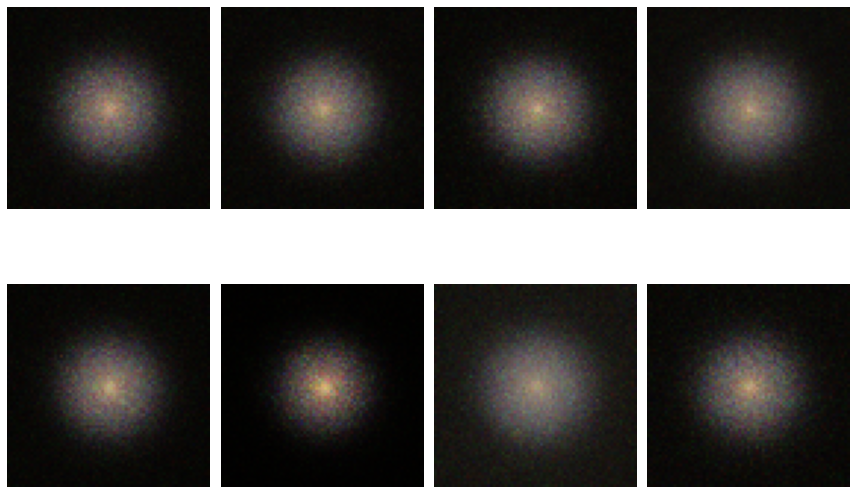

In [150]:
%matplotlib inline

# prepare random latents for 8 galaxies
rng, z_key, eval_rng = jax.random.split(rng, 3)
z = jax.random.normal(z_key, (8, latents))

# generate images
def gen(model):
  return model.generate(z)

generated_images = nn.apply(gen, model)({'params': state.params})
generated_images = unflatten(generated_images)
show_galaxies(generated_images)